# Cluster Analysis of Genres

After training and evaluating several models, we find that the accuracy is still less. One of the main reasons for this is that the list of genres that we have selected earlier having very strong similarities. The genres were selected by intuition based on their current popularity. However, technically some genre are very difficult to distinguish by the machine learning models. For example, the audio features of the genre `rock` have strong similarities with that of `pop`, `techno` has strong similarity to `metal` and `classical` is very close to `country`. In order to improve the classification accuracy, we need to select a set of genres that are very distinct. 

In this notebook, we take semi-supervised learning approach to identify genres that are distinct from each other. Our initial approach was to identify clusters of similar genres using the `KMeans` method. But this method failed to recognize any clusters due to the nature of the Spotify dataset. Therefore, we take slightly modified approach where we manually define a region for the cluster and select the genre that has highest count in that region.

## Importing modules

In [178]:
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from seaborn import heatmap

## Loading dataset

In [153]:
df = pd.read_csv('data/genre_data.csv')

# Dropping irrelavant columns
df.drop(
    ['type', 'id', 'uri', 'track_href', 'analysis_url', 'year', 'duration_ms'], 
    axis=1, 
    inplace=True
) 

In [154]:
df

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,0.382,0.416,0,-9.303,1,0.0302,0.07330,0.000000,0.0719,0.125,102.089,4,acoustic
1,0.470,0.678,4,-8.018,1,0.0587,0.25900,0.000000,0.2040,0.240,84.843,4,acoustic
2,0.557,0.290,11,-9.184,0,0.0386,0.84900,0.000000,0.7000,0.358,89.117,4,acoustic
3,0.665,0.380,4,-10.252,1,0.0325,0.06530,0.000082,0.1030,0.286,165.713,1,acoustic
4,0.716,0.774,9,-7.471,1,0.0361,0.38900,0.123000,0.2190,0.784,110.359,4,acoustic
...,...,...,...,...,...,...,...,...,...,...,...,...,...
129174,0.363,0.509,10,-6.966,1,0.0325,0.23900,0.000000,0.0911,0.245,139.740,4,world-music
129175,0.405,0.532,0,-7.063,1,0.0289,0.00788,0.000000,0.0792,0.270,157.950,3,world-music
129176,0.601,0.384,6,-11.791,1,0.0325,0.15100,0.000000,0.1050,0.394,92.008,4,world-music
129177,0.422,0.122,5,-13.476,1,0.0363,0.87900,0.000000,0.1010,0.381,145.921,4,world-music


## Scatter matrix

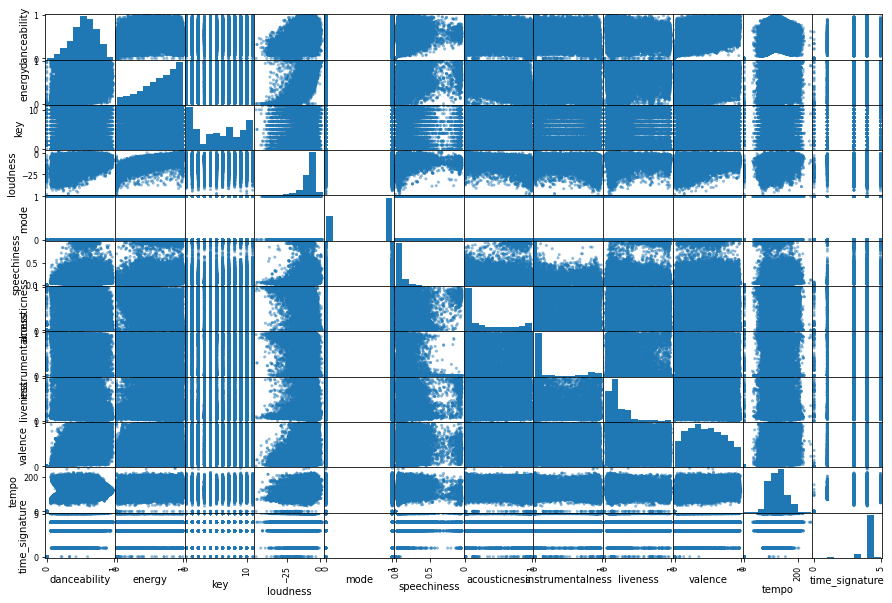

In [156]:
scatter_matrix(df, figsize=(15, 10));

For our purpose of creating distinct cluster regions, we require comparison of two features that have the data points spread through out the X-Y plane. From the `scatter_matrix` above, the comparison between the features `acousticness` and `valence` appear to be the best candidate for creating grids.

## Scatter plot of `acousticness` vs `valence`

<AxesSubplot:xlabel='acousticness', ylabel='valence'>

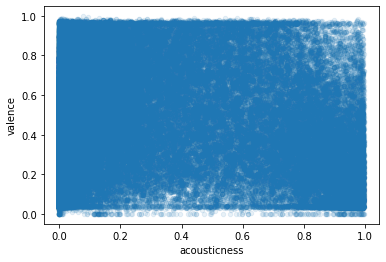

In [158]:
df[['acousticness','valence']].plot.scatter(x='acousticness', y='valence', alpha=0.1)

## Grid construction

In [161]:
# Function to make a grid for a given range
def make_grid(a_low, a_high, v_low, v_high):
    return df.loc[(
        (df['acousticness'] >= a_low) & (df['acousticness'] < a_high) &
        (df['valence'] >= v_low) & (df['valence'] < v_high)
    )]

In [162]:
grid_1 = make_grid(0, 0.33, 0, 0.33)
grid_2 = make_grid(0.33, 0.66, 0, 0.33)
grid_3 = make_grid(0.66, 1, 0, 0.33)
grid_4 = make_grid(0, 0.33, 0.33, 0.66)
grid_5 = make_grid(0.33, 0.66, 0.33, 0.66)
grid_6 = make_grid(0.66, 1, 0.33, 0.66)
grid_7 = make_grid(0, 0.33, 0.66, 1)
grid_8 = make_grid(0.33, 0.66, 0.66, 1)
grid_9 = make_grid(0.66, 1, 0.66, 1)

<AxesSubplot:xlabel='acousticness', ylabel='valence'>

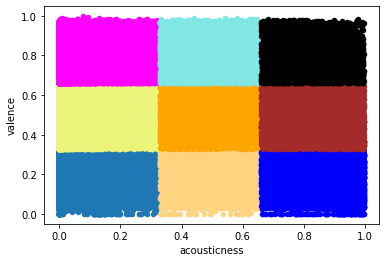

In [165]:
ax = grid_1.plot(kind='scatter', x='acousticness', y='valence')
grid_2.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='#FFD380')
grid_3.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='blue')
grid_4.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='#EDF47A')
grid_5.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='orange')
grid_6.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='brown')
grid_7.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='magenta')
grid_8.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='#80E7E5')
grid_9.plot(kind='scatter', x='acousticness', y='valence',ax=ax, color='black')

##  Grid-wise maximum genre count

In [168]:
def major_genre(df):
    counts = dict(df['genre'].value_counts())
    max_genre = max(counts, key=lambda key: counts[key])
    return max_genre

In [169]:
list(map(major_genre, 
    (cluster_1, cluster_2, cluster_3, cluster_4, cluster_5, cluster_6, cluster_7, cluster_8, cluster_9)
   ))

['black-metal',
 'mandopop',
 'classical',
 'grunge',
 'sertanejo',
 'tango',
 'reggae',
 'salsa',
 'tango']

## Retraining with new set of genres

In [170]:
genre_list_clustered = ['black-metal','mandopop','classical','grunge','sertanejo','tango','reggae','salsa','tango']
df_genre_clustered = df.loc[df['genre'].isin(genre_list_clustered)]
df_genre_clustered.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
300,0.379,0.996,2,-3.023,0,0.2850,0.004570,0.000009,0.0981,0.0386,128.049,4,black-metal
301,0.354,0.980,2,-6.128,1,0.1400,0.000021,0.867000,0.3320,0.1060,135.765,3,black-metal
302,0.151,0.996,0,-3.084,0,0.1960,0.000030,0.016000,0.4700,0.0378,89.926,4,black-metal
303,0.426,0.965,6,-9.169,1,0.0714,0.003630,0.879000,0.0617,0.1520,174.226,4,black-metal
304,0.110,0.969,1,-5.858,0,0.1240,0.000003,0.779000,0.1510,0.1700,79.762,4,black-metal


In [171]:
from sklearn.model_selection import StratifiedShuffleSplit
X = df_genre_clustered.drop('genre', axis=1)
y, labels = pd.factorize(df_genre_clustered['genre'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=43)

In [172]:
model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)

RandomForestClassifier()

## Performance

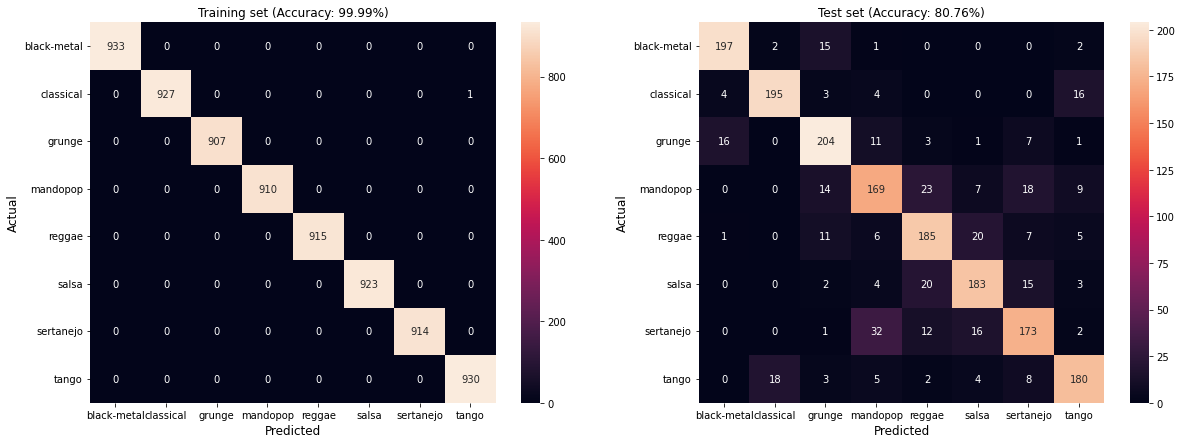

In [173]:
fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (20, 7))
# Training set
y_train_pred = model_rfc.predict(X_train)
train_accuracy = model_rfc.score(X_train, y_train)
heatmap (pd.crosstab(labels[y_train], labels[y_train_pred]), 
         annot = True, 
         fmt = 'd', 
         ax = ax1
)
ax1.set_title (f'Training set (Accuracy: {round(train_accuracy*100, 2)}%)')
ax1.set_xlabel ('Predicted' , fontsize = 12)
ax1.set_ylabel ('Actual', fontsize = 12);

# Test set
y_test_pred = model_rfc.predict(X_test)
train_accuracy = model_rfc.score(X_test, y_test)
heatmap (pd.crosstab(labels[y_test], labels[y_test_pred]), 
         annot = True, 
         fmt = 'd',
         ax = ax2
)
ax2.set_title (f'Test set (Accuracy: {round(train_accuracy*100, 2)}%)')
ax2.set_xlabel ('Predicted' , fontsize = 12)
ax2.set_ylabel ('Actual', fontsize = 12);

In [174]:
print("""
    Performance after hyperparameters tuning
    ----------------------------------------
    Model:\tRandom Forest Classifier
    Accuracy on training set:\t{}
    Accuracy on test set:\t{}
""".format(
    model_rfc.score(X_train, y_train),
    model_rfc.score(X_test, y_test)
))


    Performance after hyperparameters tuning
    ----------------------------------------
    Model:	Random Forest Classifier
    Accuracy on training set:	0.9998641304347826
    Accuracy on test set:	0.8076086956521739



## Cross validation score

In [180]:
cv = StratifiedKFold (3, shuffle = True, random_state = 43)
scores = cross_val_score(model_rfc, X_train, y_train, scoring = 'accuracy', cv = cv, n_jobs = -1)
print("""
    Cross validation scores
    -----------------------
    {}
""".format(scores))


    Cross validation scores
    -----------------------
    [0.81377343 0.79902161 0.81084386]



In [190]:
df['genre'].unique().shape

(114,)

In [191]:
df = pd.read_csv('data/genre_data.csv')

In [192]:
df.shape

(129179, 20)